In [1]:
import ipywidgets as widgets
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys

# embed images in the notebook
%matplotlib inline

sys.path.append('../..')

from solution import solarpvutil

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

spv = solarpvutil.SolarPVUtil()

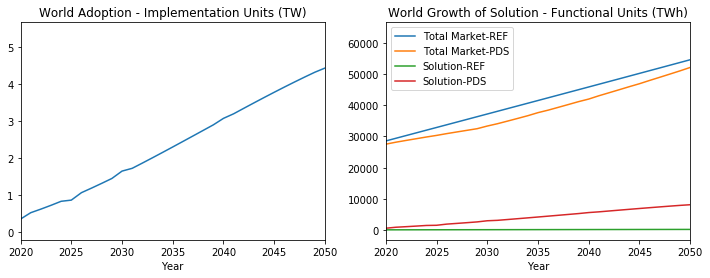

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax[0].set_title('World Adoption - Implementation Units (TW)')
spv.ua.soln_pds_tot_iunits_reqd()['World'].plot(ax=ax[0], xlim=(2020, 2050))

ax[1].set_title('World Growth of Solution - Functional Units (TWh)')
spv.tm.ref_tam_per_region()['World'].plot(ax=ax[1], legend=True, label='Total Market-REF', xlim=(2020, 2050))
spv.tm.pds_tam_per_region()['World'].plot(ax=ax[1], legend=True, label='Total Market-PDS', xlim=(2020, 2050))
spv.ht.soln_ref_funits_adopted()['World'].plot(ax=ax[1], legend=True, label='Solution-REF', xlim=(2020, 2050))
spv.ht.soln_pds_funits_adopted()['World'].plot(ax=ax[1], legend=True, label='Solution-PDS', xlim=(2020, 2050))


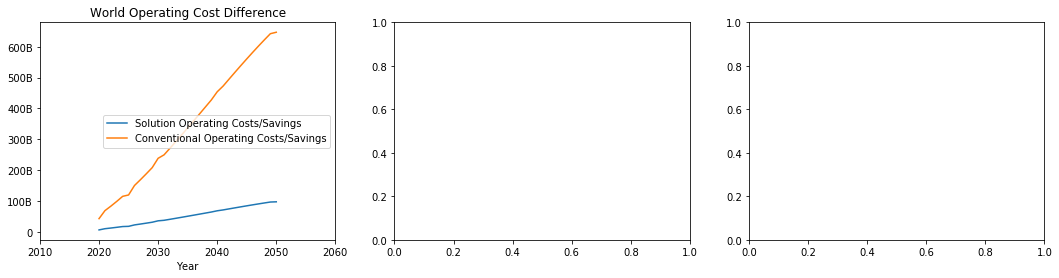

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

ax[0].set_title('World Operating Cost Difference')
ax[0].set_xlim(left=2010, right=2060)
ax[0].set_xlabel('Billions US$2014')
matplotlib.ticker.EngFormatter.ENG_PREFIXES[9] = 'B'
fmty = matplotlib.ticker.EngFormatter(sep='')
ax[0].yaxis.set_major_formatter(fmty)
spv.oc.soln_pds_annual_operating_cost().loc[2020:2050].plot(ax=ax[0], legend=True, label='Solution Operating Costs/Savings')
spv.oc.conv_ref_annual_operating_cost().loc[2020:2050].plot(ax=ax[0], legend=True, label='Conventional Operating Costs/Savings')


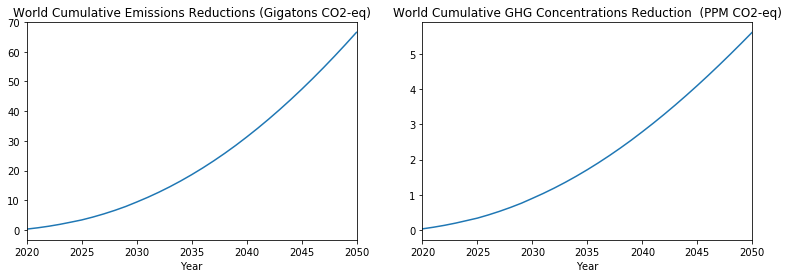

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
ax[0].set_title('World Cumulative Emissions Reductions (Gigatons CO2-eq)')
ax[0].set_xlim(left=2020, right=2050)
spv.c2.co2eq_mmt_reduced()['World'].cumsum().mul(0.001).plot(ax=ax[0], legend=False)
ax[1].set_title('World Cumulative GHG Concentrations Reduction  (PPM CO2-eq)')
ax[1].set_xlim(left=2020, right=2050)
spv.c2.co2eq_ppm_calculator()['CO2-eq PPM'].plot(ax=ax[1], legend=False)